In this scenario, we have to make ARIMA model over shampoo sales data and check the MSE between predicted and actual value.

Data can be downloaded in .csv format from the following links:

https://datamarket.com/data/set/22r0/sales-of-shampoo-over-a-three-year-period#!ds=22r0&display=line

https://www.kaggle.com/datasets/redwankarimsony/shampoo-saled-dataset

# Import Libraries

In [1]:
#!pip install pmdarima
#!pip install --upgrade matplotlib

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import GridSearchCV
import pickle
#from scipy.special import inv_boxcox
#from scipy import stats
%matplotlib inline

# Import Dataset

In [3]:
def parser(x):
    return pd.datetime.strptime('202'+x, '%Y-%m') #'202'

In [4]:
shampoo = pd.read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

C:\Users\Jonathon\AppData\Local\Temp/ipykernel_38432/1457422742.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  return pd.datetime.strptime('202'+x, '%Y-%m') #'202'


In [5]:
shampoo

Month
2021-01-01    266.0
2021-02-01    145.9
2021-03-01    183.1
2021-04-01    119.3
2021-05-01    180.3
2021-06-01    168.5
2021-07-01    231.8
2021-08-01    224.5
2021-09-01    192.8
2021-10-01    122.9
2021-11-01    336.5
2021-12-01    185.9
2022-01-01    194.3
2022-02-01    149.5
2022-03-01    210.1
2022-04-01    273.3
2022-05-01    191.4
2022-06-01    287.0
2022-07-01    226.0
2022-08-01    303.6
2022-09-01    289.9
2022-10-01    421.6
2022-11-01    264.5
2022-12-01    342.3
2023-01-01    339.7
2023-02-01    440.4
2023-03-01    315.9
2023-04-01    439.3
2023-05-01    401.3
2023-06-01    437.4
2023-07-01    575.5
2023-08-01    407.6
2023-09-01    682.0
2023-10-01    475.3
2023-11-01    581.3
2023-12-01    646.9
Name: Sales, dtype: float64

# EDA

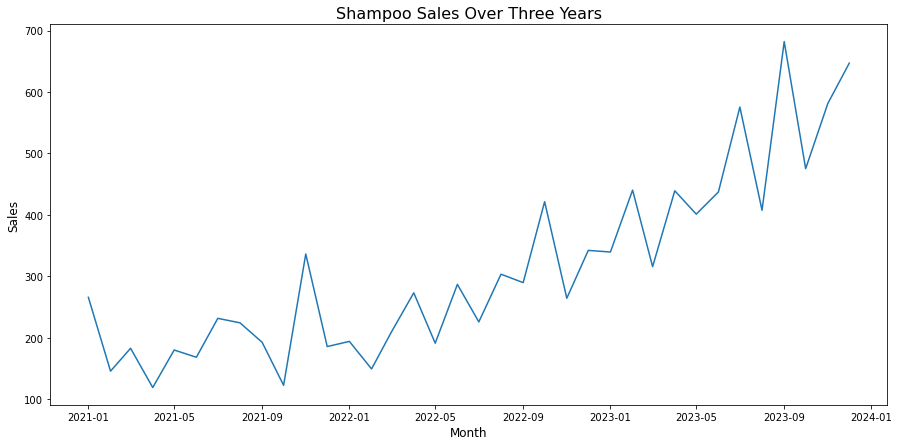

In [6]:
plt.figure(figsize=(15,7))
plt.plot(shampoo.index.values, shampoo.values)
plt.title("Shampoo Sales Over Three Years", fontsize=16)
plt.ylabel("Sales", fontsize=12)
plt.xlabel("Month", fontsize=12)
plt.show()

# Data Preparation

In [7]:
#perform Box-Cox Transformation on Sales if ARIMA model without transformation performs poorly
#shampoo_transformed, lmda = stats.boxcox(shampoo.values)
#print("Best lambda for transformation:", lmda)

In [8]:
#shampoo_t_series_transformed = pd.Series(data=shampoo_transformed,
#                                         index=shampoo.index.values)

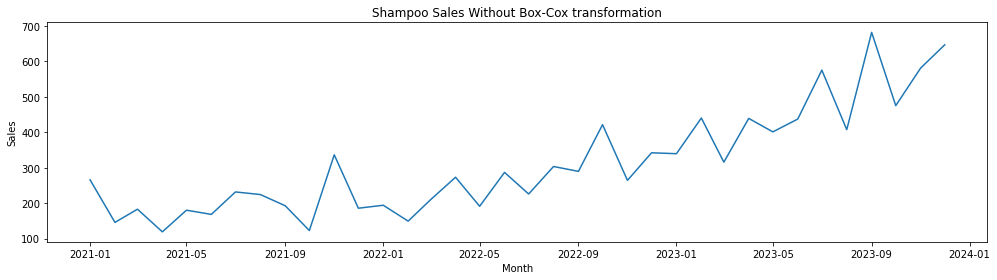

In [9]:
fig, ax = plt.subplots(1, figsize=(14, 4))
ax.plot(shampoo.index, shampoo.values)
ax.set_title(f"Shampoo Sales Without Box-Cox transformation")
ax.set_ylabel("Sales")
ax.set_xlabel("Month")
#ax.set_title(f"Shampoo Sales With Box-Cox transformation")
fig.tight_layout()

# Modeling

## Auto ARIMA (no seasonality)

### Check for stationarity statistically

In [10]:
#p-value much less than alpha of 0.05 for differenced series???
adf_shampoo = sm.tsa.stattools.adfuller(shampoo.diff().dropna())
print("ADF p-value for differenced series: {0}".format(adf_shampoo[1]))
# ARIMA model is stationary (not necessary to perform Box-Cox transformation)

ADF p-value for differenced series: 1.799857414168716e-10


In [11]:
df_shampoo = pd.DataFrame(shampoo)
df_shampoo.reset_index(inplace=True)
df_shampoo

,Month,Sales
0,2021-01-01,266.0
1,2021-02-01,145.9
2,2021-03-01,183.1
3,2021-04-01,119.3
4,2021-05-01,180.3
5,2021-06-01,168.5
6,2021-07-01,231.8
7,2021-08-01,224.5
8,2021-09-01,192.8
9,2021-10-01,122.9


### Check for stationarity visually (and ACF/PACF plots for reference)

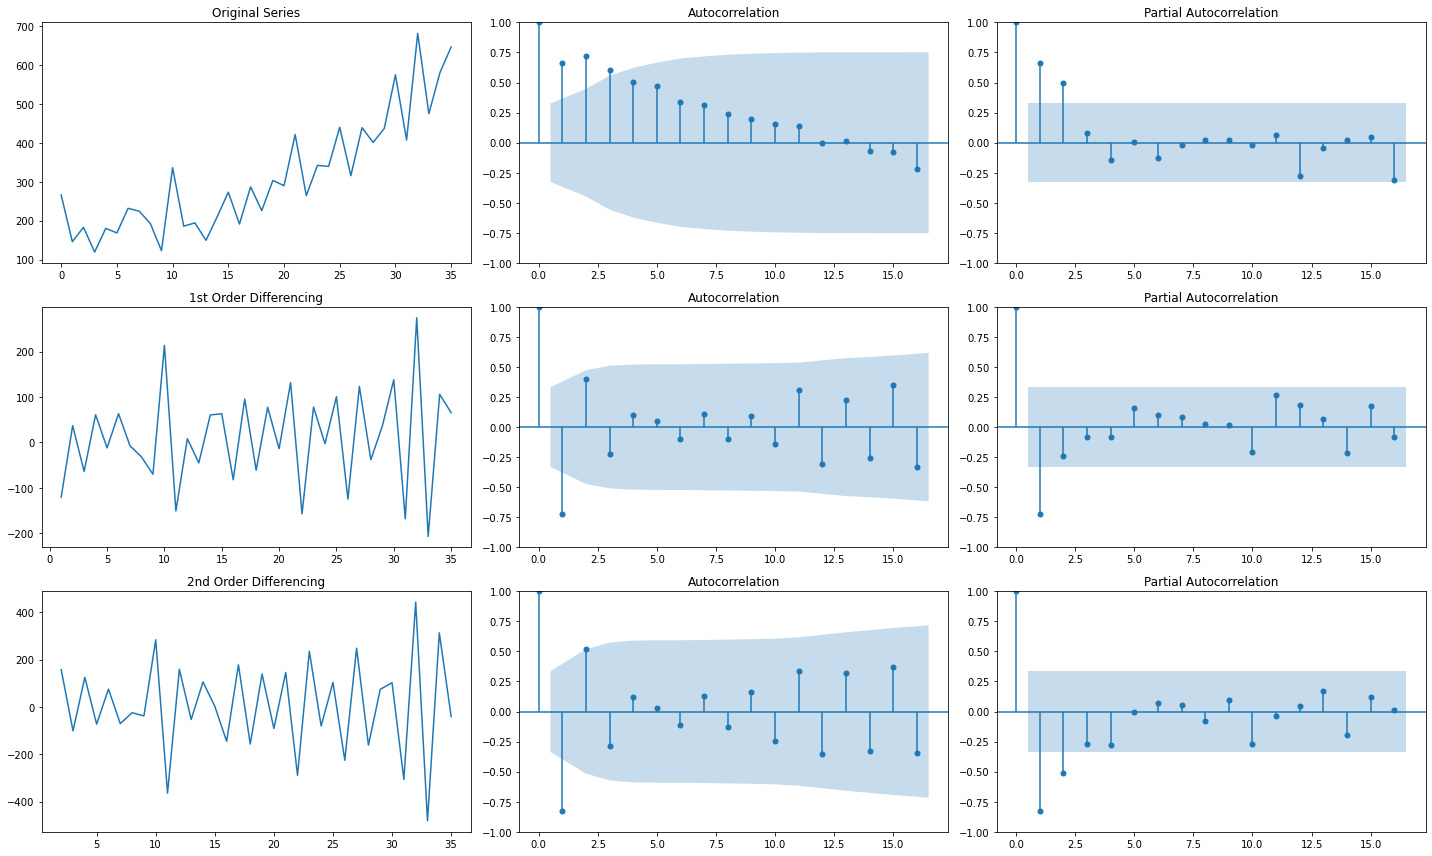

In [12]:
#ACF plot - number of MA terms, PACF - number of AR terms
# Original Series
fig, axes = plt.subplots(3, 3, figsize=(20,12))
axes[0, 0].plot(df_shampoo['Sales']); axes[0, 0].set_title('Original Series')
plot_acf(df_shampoo['Sales'].values, ax=axes[0, 1]) # autocorrelation plot
plot_pacf(df_shampoo['Sales'].values, ax=axes[0, 2]) #partial autocorrelation plot

# 1st Differencing
axes[1, 0].plot(df_shampoo['Sales'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_shampoo['Sales'].diff().dropna(), ax=axes[1, 1]) # autocorrelation plot
plot_pacf(df_shampoo['Sales'].diff().dropna(), ax=axes[1, 2]) #partial autocorrelation plot

# 2nd Differencing
axes[2, 0].plot(df_shampoo['Sales'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_shampoo['Sales'].diff().diff().dropna(), ax=axes[2, 1]) # autocorrelation plot
plot_pacf(df_shampoo['Sales'].diff().diff().dropna(), ax=axes[2, 2]) #partial autocorrelation plot

fig.tight_layout() # spacing between plots
plt.show()

### Fit Model

In [13]:
# Fit your model
auto_arima_model = pm.auto_arima(shampoo, seasonal=False)

In [14]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   36
Model:               SARIMAX(1, 1, 2)   Log Likelihood                -195.731
Date:                Sat, 30 Dec 2023   AIC                            401.463
Time:                        00:14:16   BIC                            409.240
Sample:                    01-01-2021   HQIC                           404.147
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.3003      6.173      1.507      0.132      -2.798      21.399
ar.L1          0.0892      0.313      0.284      0.776      -0.525       0.704
ma.L1         -1.3870      0.315     -4.401      0.000      -2.005      -0.769
ma.L2          0.9424      0.449      2.097      0.036       0.061       1.823
sigma2      3695.5029   1457.945      2.535      0.011     837.982    6553.023
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):                 0.81
Prob(Q):                              0.64   Prob(JB):                         0.67
Heteroskedasticity (H):               0.95   Skew:                             0.30
Prob(H) (two-sided):                  0.93   Kurtosis:                         2.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
# 1,1,2 ARIMA Model (as determined by auto_arima())
arima_model1 = SARIMAX(shampoo, order=(1, 1, 2)).fit()
arima_model1.summary()

C:\Users\Jonathon\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Jonathon\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   36
Model:               SARIMAX(1, 1, 2)   Log Likelihood                -196.631
Date:                Sat, 30 Dec 2023   AIC                            401.263
Time:                        00:14:16   BIC                            407.484
Sample:                    01-01-2021   HQIC                           403.411
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0894      0.346      0.258      0.796      -0.589       0.768
ma.L1         -1.3186      2.951     -0.447      0.655      -7.103       4.466
ma.L2          0.9944      4.393      0.226      0.821      -7.616       9.605
sigma2      3747.0261   1.63e+04      0.230      0.818   -2.81e+04    3.56e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.03
Prob(Q):                              0.96   Prob(JB):                         0.99
Heteroskedasticity (H):               1.04   Skew:                             0.03
Prob(H) (two-sided):                  0.94   Kurtosis:                         2.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Auto ARIMA (w/ seasonality)

### Grid Search

In [16]:
# Now to increase the accuracy of the model, we'll use grid search on seasonality parameter
shampoo_models_auto_arima_seasonal = []
for i in range(1, 7):
    shampoo_models_auto_arima_seasonal.append(pm.auto_arima(shampoo, seasonal = True, m = i))

In [18]:
i = 1
for model in shampoo_models_auto_arima_seasonal:
    print(f'm={i}')
    print('\n')
    print(model.summary())
    print('\n'*3)
    i += 1

m=1


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   36
Model:               SARIMAX(1, 1, 2)   Log Likelihood                -195.731
Date:                Sat, 30 Dec 2023   AIC                            401.463
Time:                        00:15:53   BIC                            409.240
Sample:                    01-01-2021   HQIC                           404.147
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.3003      6.173      1.507      0.132      -2.798      21.399
ar.L1          0.0892      0.313      0.284      0.776      -0.525       0.704
ma.L1         -1.3870      0.315     -4.401   

In [19]:
shampoo_models_arima_seasonal = []

# m=1
#same as non-seasonal auto-arima model (skip)

# m=2
shampoo_models_arima_seasonal.append(SARIMAX(shampoo, order=(1, 1, 1)).fit())

# m=3
#same as model for m=1 (skip)

# m=4
shampoo_models_arima_seasonal.append(SARIMAX(shampoo, order=(2, 1, 0), seasonal_order=(0, 0, [1], 4)).fit())

# m=5
shampoo_models_arima_seasonal.append(SARIMAX(shampoo, order=(1, 1, 1), seasonal_order=(0, 0, [1, 2], 5)).fit())

# m=6
#same as non-seasonal auto-arima model (skip)

C:\Users\Jonathon\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Jonathon\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Jonathon\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Jonathon\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Jonathon\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS w

In [20]:
for model in shampoo_models_arima_seasonal:
    print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   36
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -200.391
Date:                Sat, 30 Dec 2023   AIC                            406.782
Time:                        00:16:09   BIC                            411.448
Sample:                    01-01-2021   HQIC                           408.393
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6003      0.201     -2.980      0.003      -0.995      -0.205
ma.L1         -0.2756      0.267     -1.033      0.302      -0.799       0.248
sigma2      5382.0425   1386.817      3.881      0.0

### Determine Best Model (lowest MSE)

In [21]:
# models to compare mse scores and select lowest MSE
shampoo_models_arima_seasonal, arima_model1

([<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x167198b86d0>,
 <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x16719f76dc0>)

In [22]:
models = shampoo_models_arima_seasonal + [arima_model1]
models

In [23]:
actual = shampoo[1:] # first term cannot be predicted with ARIMA
actual

Month
2021-02-01    145.9
2021-03-01    183.1
2021-04-01    119.3
2021-05-01    180.3
2021-06-01    168.5
2021-07-01    231.8
2021-08-01    224.5
2021-09-01    192.8
2021-10-01    122.9
2021-11-01    336.5
2021-12-01    185.9
2022-01-01    194.3
2022-02-01    149.5
2022-03-01    210.1
2022-04-01    273.3
2022-05-01    191.4
2022-06-01    287.0
2022-07-01    226.0
2022-08-01    303.6
2022-09-01    289.9
2022-10-01    421.6
2022-11-01    264.5
2022-12-01    342.3
2023-01-01    339.7
2023-02-01    440.4
2023-03-01    315.9
2023-04-01    439.3
2023-05-01    401.3
2023-06-01    437.4
2023-07-01    575.5
2023-08-01    407.6
2023-09-01    682.0
2023-10-01    475.3
2023-11-01    581.3
2023-12-01    646.9
Name: Sales, dtype: float64

In [24]:
models_mse = []
for model in models:
    pred = model.predict(1) # first term cannot be predicted with ARIMA
    mse = mean_squared_error(actual, pred)
    models_mse.append(mse)    

In [25]:
models_mse # 2nd model in list of models has lowest mse (best model)

[5592.999232428705, 4490.2520790618955, 4502.315784199613, 4539.556112517681]

In [26]:
arima_model_optimal = SARIMAX(shampoo, order=(2, 1, 0), seasonal_order=(0, 0, [1], 4)).fit()
arima_model_optimal

C:\Users\Jonathon\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Jonathon\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


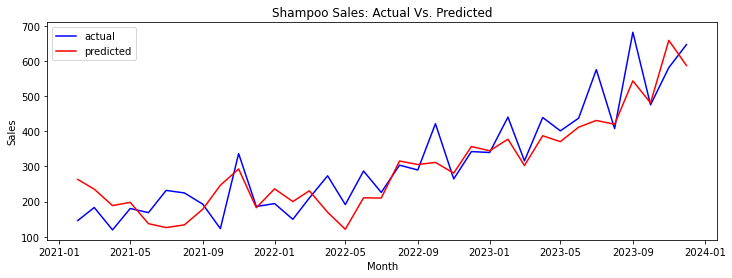

In [27]:
# Visualize actual vs. predicted
pred = arima_model_optimal.predict(1)
fig, ax = plt.subplots(figsize = (12,4))
ax.plot(shampoo.index.values[1:], shampoo.values[1:], c='blue', label='actual')
ax.plot(shampoo.index.values[1:], pred, c='red', label='predicted')
ax.set_xlabel('Month')
ax.set_ylabel('Sales')
ax.set_title('Shampoo Sales: Actual Vs. Predicted')
ax.legend()
plt.show()

In [28]:
# make your forecasts
forecasts_shampoo = []

# predict N=3 steps into the future
for i in range(36, 39):    
    forecasts_shampoo.append(arima_model_optimal.predict(i))

forecasts_shampoo

[2024-01-01    605.741973
 Freq: MS, dtype: float64,
 2024-02-01    605.268361
 Freq: MS, dtype: float64,
 2024-03-01    568.878801
 Freq: MS, dtype: float64]

In [29]:
x_forecasts = [shampoo.index.values[-1]] + [forecast.index.values[0] for forecast in forecasts_shampoo]
x_forecasts

[numpy.datetime64('2023-12-01T00:00:00.000000000'),
 numpy.datetime64('2024-01-01T00:00:00.000000000'),
 numpy.datetime64('2024-02-01T00:00:00.000000000'),
 numpy.datetime64('2024-03-01T00:00:00.000000000')]

In [30]:
y_forecasts = [shampoo.values[-1]] + [forecast.values[0] for forecast in forecasts_shampoo]
y_forecasts

[646.9, 605.7419730392752, 605.268360569018, 568.8788009165929]

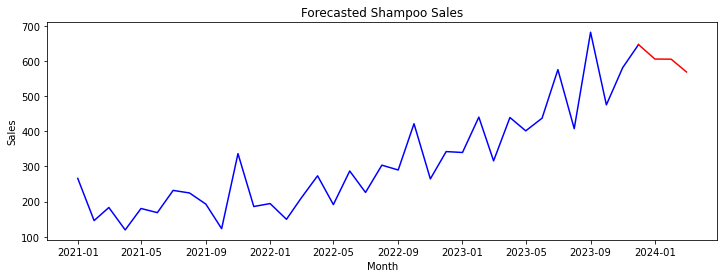

In [31]:
# Visualize the forecasts
fig, ax = plt.subplots(figsize = (12,4))
ax.plot(shampoo.index.values, shampoo.values, c='blue')
ax.plot(x_forecasts, y_forecasts, c='red')
ax.set_xlabel('Month')
ax.set_ylabel('Sales')
ax.set_title('Forecasted Shampoo Sales')
plt.show()

In [32]:
#best-fit model determined using mse metric...save optimal model

# Save Model

In [33]:
#save model
with open("arima_model.pkl", "wb") as f:
    pickle.dump(arima_model_optimal, f)